In [1]:
library("dplyr")
library("ggplot2")
library(MCMCpack)
library(gridExtra)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Warning message:
“package ‘MCMCpack’ was built under R version 3.6.3”Loading required package: coda
Warning message:
“package ‘coda’ was built under R version 3.6.3”Loading required package: MASS

Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select

##
## Markov Chain Monte Carlo Package (MCMCpack)
## Copyright (C) 2003-2020 Andrew D. Martin, Kevin M. Quinn, and Jong Hee Park
##
## Support provided by the U.S. National Science Foundation
## (Grants SES-0350646 and SES-0350613)
##
Warning message:
“package ‘gridExtra’ was built under R version 3.6.3”
Attaching package: ‘gridExtra’

The following object is masked fro

In [2]:
data_all<-read.csv('./winemag-data-130k-v2.csv')

In [3]:
data<-droplevels(na.omit(data_all))

In [4]:
filtered_data<-data[(data$country=='South Africa' & data$variety=='Sauvignon Blanc')|(data$country=='Chile' & data$variety=='Chardonnay'),] 
filtered_data<-filtered_data[filtered_data$price==15,]
filtered_data<-droplevels(filtered_data)

head(data_q1a)

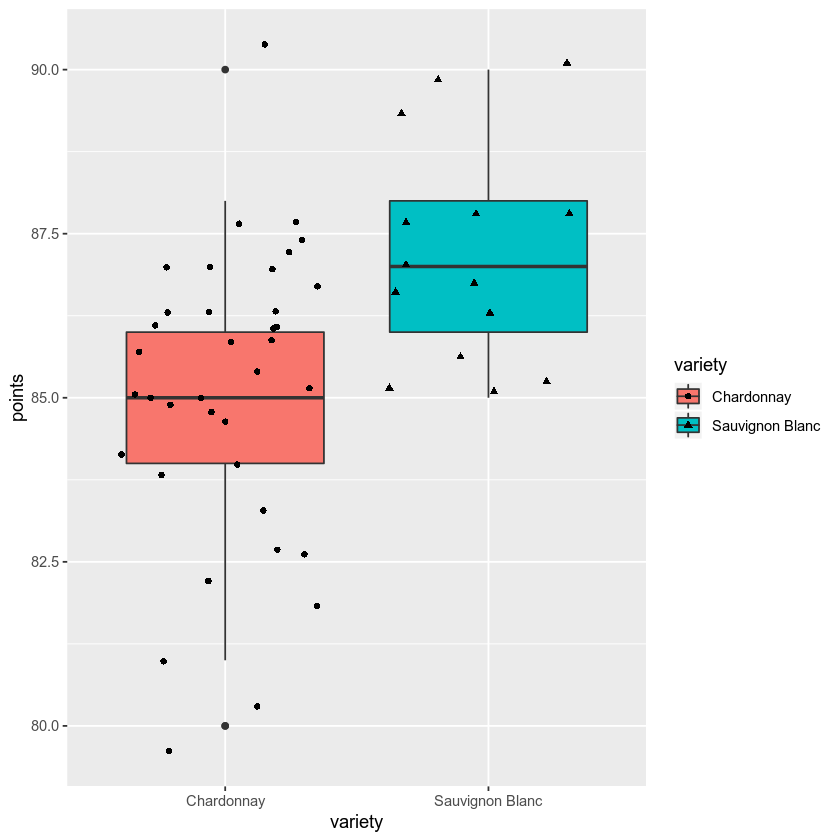

In [5]:
ggplot(filtered_data) + geom_boxplot(aes(variety, points, fill = variety)) + geom_jitter(aes(variety,points, shape = variety))

In [6]:
tapply(filtered_data$points, filtered_data$variety, length)
tapply(filtered_data$points, filtered_data$variety, mean)
tapply(filtered_data$points, filtered_data$variety, median)
tapply(filtered_data$points, filtered_data$variety, sd)

Chardonnay Sauvignon Blanc 
             37              14

Chardonnay Sauvignon Blanc 
       85.08108        87.21429

Chardonnay Sauvignon Blanc 
             85              87

Chardonnay Sauvignon Blanc 
       2.203260        1.717716

In [7]:
bartlett.test(points ~ variety, data = filtered_data)


	Bartlett test of homogeneity of variances

data:  points by variety
Bartlett's K-squared = 1.0591, df = 1, p-value = 0.3034


In [8]:
south_africa_filtered_data<-filtered_data[(filtered_data$country=='South Africa' & filtered_data$variety=='Sauvignon Blanc'),]
chile_filtered_data<-filtered_data[(filtered_data$country=='Chile' & filtered_data$variety=='Chardonnay'),]

In [10]:
dim(south_africa_filtered_data)

[1] 14 14

In [11]:
shapiro.test(south_africa_filtered_data$points)


	Shapiro-Wilk normality test

data:  south_africa_filtered_data$points
W = 0.92273, p-value = 0.2407


In [12]:
shapiro.test(chile_filtered_data$points)


	Shapiro-Wilk normality test

data:  chile_filtered_data$points
W = 0.94394, p-value = 0.06162


In [13]:
t.test(points ~ variety, data=filtered_data, paired=FALSE, var.equal = TRUE)


	Two Sample t-test

data:  points by variety
t = -3.2599, df = 49, p-value = 0.00203
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -3.4482245 -0.8181847
sample estimates:
     mean in group Chardonnay mean in group Sauvignon Blanc 
                     85.08108                      87.21429 


In [14]:
var.test(points ~ variety, data=filtered_data)


	F test to compare two variances

data:  points by variety
F = 1.6452, num df = 36, denom df = 13, p-value = 0.3372
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.5877808 3.7659436
sample estimates:
ratio of variances 
          1.645237 


In [15]:
t.test(points ~ variety, data=filtered_data, var.equal = TRUE)


	Two Sample t-test

data:  points by variety
t = -3.2599, df = 49, p-value = 0.00203
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -3.4482245 -0.8181847
sample estimates:
     mean in group Chardonnay mean in group Sauvignon Blanc 
                     85.08108                      87.21429 


In [16]:
t.test(points ~ variety, data=filtered_data, alternative = 'less')


	Welch Two Sample t-test

data:  points by variety
t = -3.648, df = 30.022, p-value = 0.0004969
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
      -Inf -1.140726
sample estimates:
     mean in group Chardonnay mean in group Sauvignon Blanc 
                     85.08108                      87.21429 


In [17]:
1/(sd(filtered_data$points)*sd(filtered_data$points))

[1] 0.1928021


Quantile (q) = 0.025
Accuracy (r) = +/- 0.005
Probability (s) = 0.95 
                                           
     Burn-in  Total Lower bound  Dependence
     (M)      (N)   (Nmin)       factor (I)
 mu  3        4232  3746         1.13      
 del 3        4095  3746         1.09      
 tau 2        3802  3746         1.01      


mu        del        tau 
86.1427074  1.0913791  0.1638502

mu        del        tau 
0.38588947 0.38713464 0.03243072

[1] 2.507269

[1] 0.252412

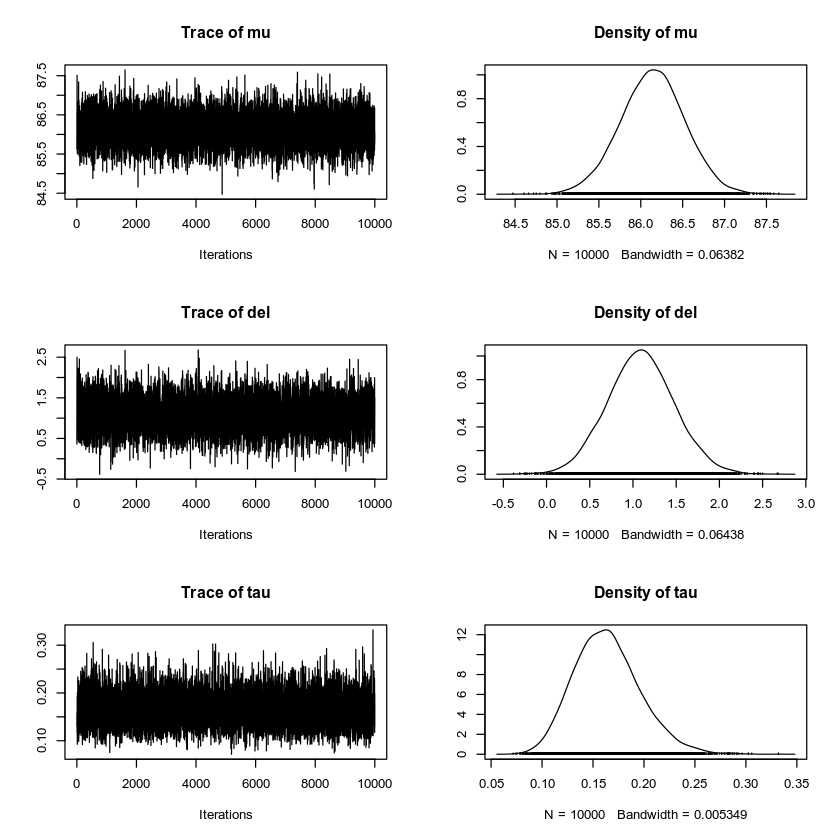

In [18]:
compare_2_gibbs <- function(y, ind, mu0 = 85.67, tau0 = 0.193, del0 = 2.13, gamma0 = 1/400, 
                            a0 = 1, b0 = 50, maxiter =10000)
{
  y1 <- y[ind == 'Sauvignon Blanc']
  y2 <- y[ind == 'Chardonnay']
  
  n1 <- length(y1) 
  n2 <- length(y2)

  ##### starting values
  mu <- (mean(y1) + mean(y2)) / 2
  del <- (mean(y1) - mean(y2)) / 2
  
  mat_store <- matrix(0, nrow = maxiter, ncol = 3)
  #####
  
  ##### Gibbs sampler
  an <- a0 + (n1 + n2)/2
  
  for(s in 1 : maxiter) 
  {
    
    ##update tau
    bn <- b0 + 0.5 * (sum((y1 - mu - del) ^ 2) + sum((y2 - mu + del) ^ 2))
    tau <- rgamma(1, an, bn)
    ##
    
    ##update mu
    taun <-  tau0 + tau * (n1 + n2)
    mun <- (tau0 * mu0 + tau * (sum(y1 - del) + sum(y2 + del))) / taun
    mu <- rnorm(1, mun, sqrt(1/taun))
    ##
    
    ##update del
    gamman <-  tau0 + tau*(n1 + n2)
    deln <- ( del0 * tau0 + tau * (sum(y1 - mu) - sum(y2 - mu))) / gamman
    del<-rnorm(1, deln, sqrt(1/gamman))
    ##
    
    ## store parameter values
    mat_store[s, ] <- c(mu, del, tau)
  }
  colnames(mat_store) <- c("mu", "del", "tau")
  return(mat_store)
}

#fitting the model
library(MCMCpack)
fit <- compare_2_gibbs(filtered_data$points, as.factor(filtered_data$variety))
plot(as.mcmc(fit),smooth=0)



#basic stats of posterior
raftery.diag(as.mcmc(fit))
apply(fit, 2, mean)
apply(fit, 2, sd)
mean(1/sqrt(fit[, 3]))
sd(1/sqrt(fit[, 3]))

#mean(filtered_data$points)
#sd(filtered_data$points)
#t <- 1/(sd(filtered_data$points)*sd(filtered_data$points))
#del <- mean(south_africa_filtered_data$points) - mean(chile_filtered_data$points)
#del

svg 
  3

png 
  2

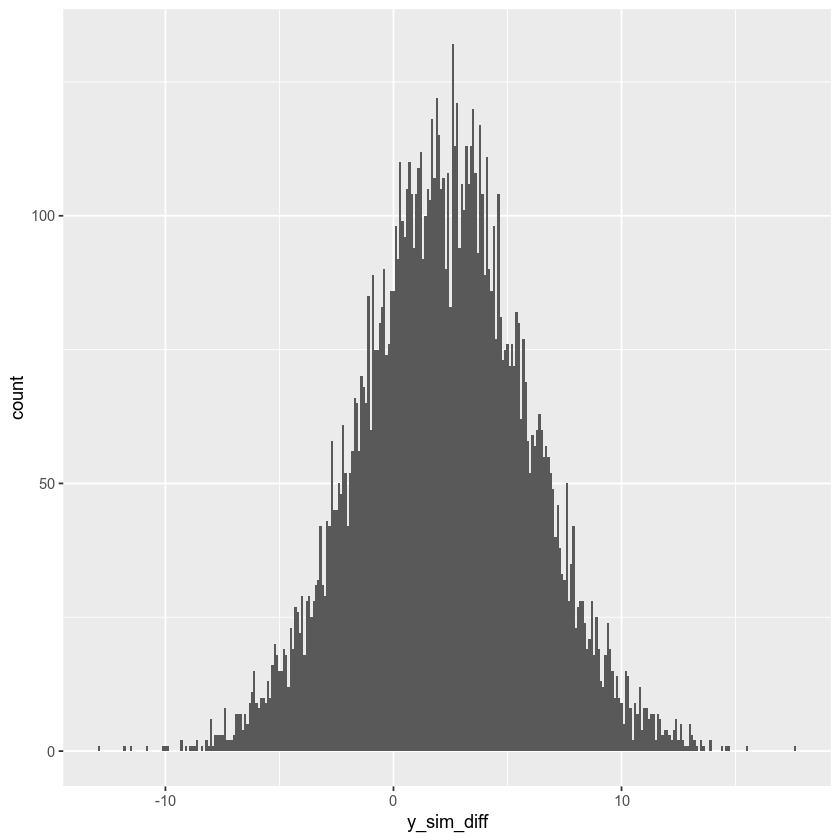

In [19]:
#simulating the two classes
y1_sim <- rnorm(10000, fit[, 1] + fit[, 2], sd = 1/sqrt(fit[, 3]))
y2_sim <- rnorm(10000, fit[, 1] - fit[, 2], sd = 1/sqrt(fit[, 3]))

#looking at the differences in points
ggplot(data.frame(y_sim_diff = y1_sim - y2_sim)) + stat_bin(aes(y_sim_diff),binwidth=0.1)
dev.copy(svg,'myplot2.svg')
dev.off()

In [20]:
scatter <- ggplot(data.frame(y1_sim, y2_sim)) + geom_point(aes(y1_sim, y2_sim), alpha = 0.3) + geom_abline(slope = 1, intercept = 0)

svg 
  3

png 
  2

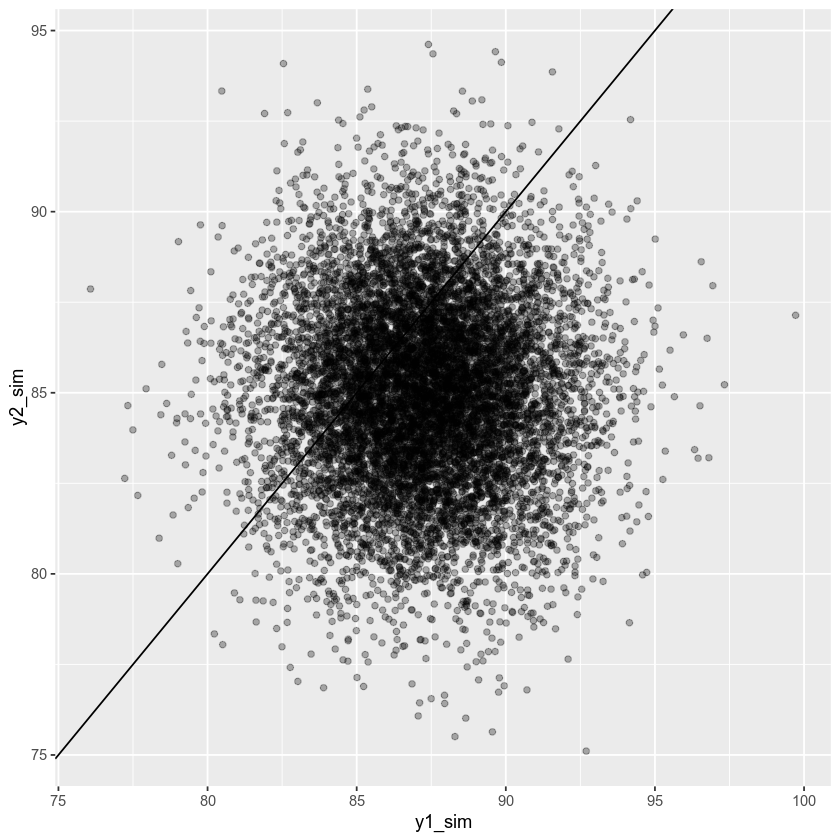

In [21]:
scatter
dev.copy(svg,'myplot3.svg')
dev.off()

In [22]:
hist_right <- ggplot()+geom_histogram(aes(y2_sim))+coord_flip()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


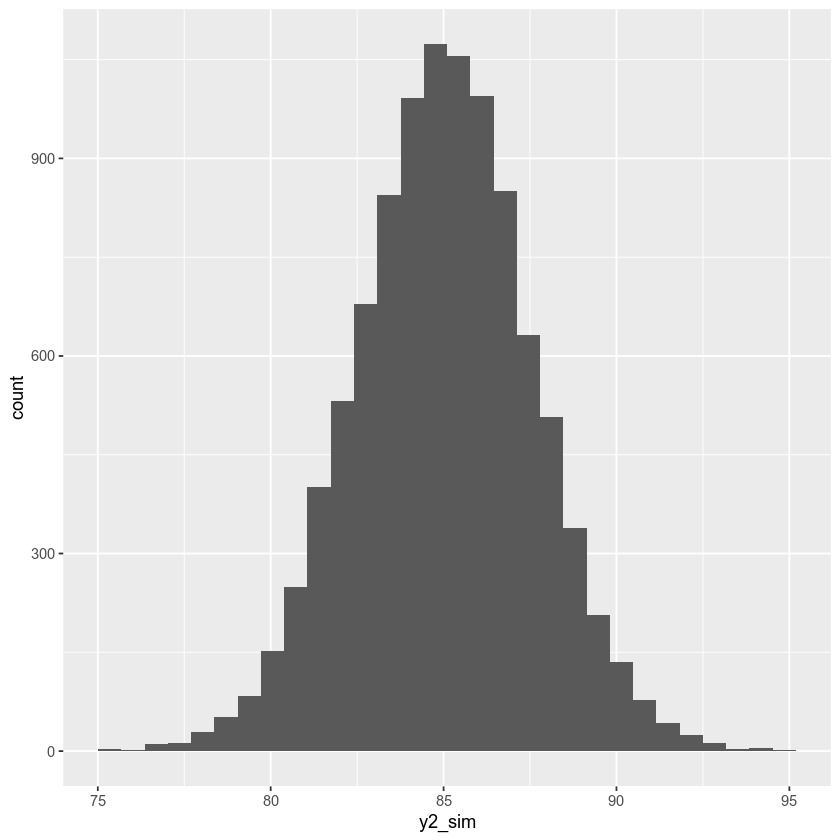

In [23]:
ggplot()+geom_histogram(aes(y2_sim))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


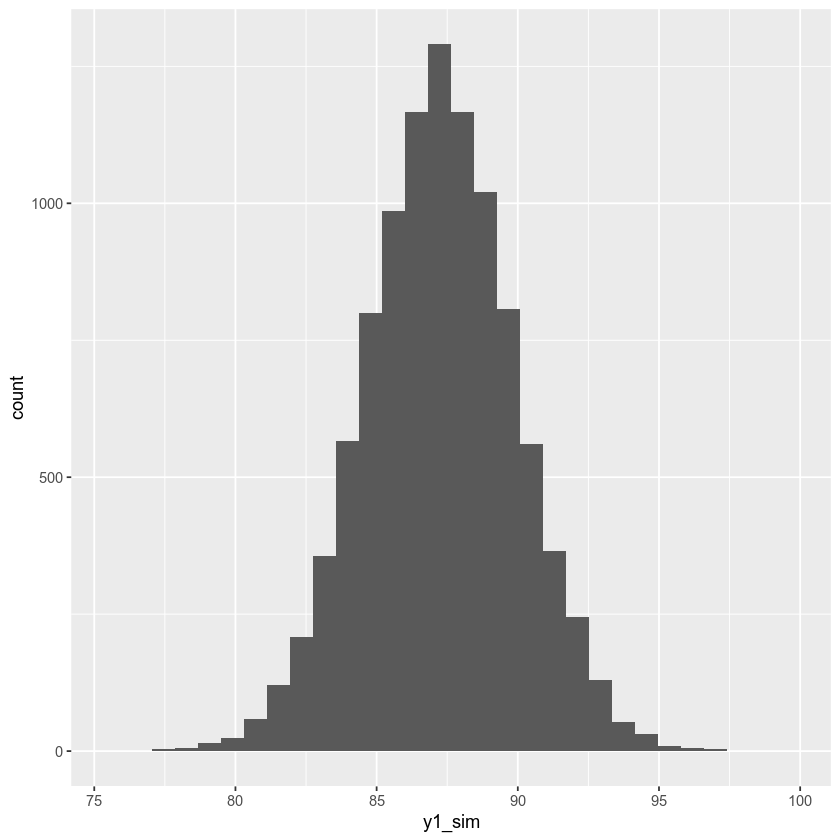

In [24]:
ggplot()+geom_histogram(aes(y1_sim))

In [25]:
hist_top <- ggplot()+geom_histogram(aes(y1_sim))
empty <- ggplot()+geom_point(aes(1,1), colour="white")+
  theme(axis.ticks=element_blank(), 
        panel.background=element_blank(), 
        axis.text.x=element_blank(), axis.text.y=element_blank(),           
        axis.title.x=element_blank(), axis.title.y=element_blank())

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


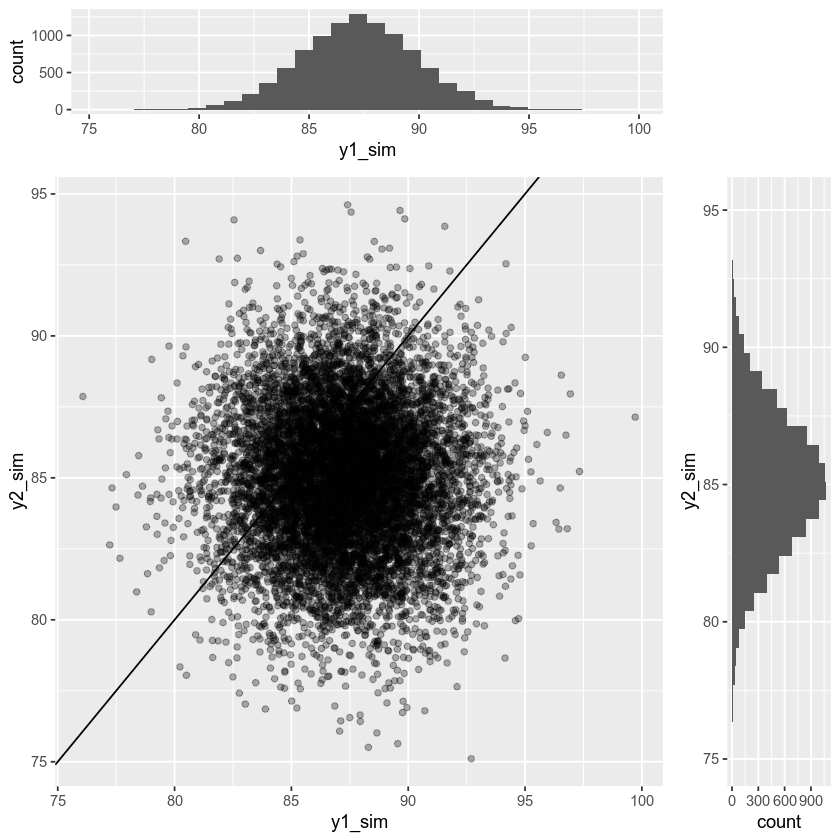

In [26]:
grid.arrange(hist_top, empty, scatter, hist_right, ncol=2, nrow=2, widths=c(4, 1), heights=c(1, 4))

In [27]:
mean(y1_sim > y2_sim)

[1] 0.7332

In [28]:
filtered_wines = filter(data_all, (country == "Italy"  & price < 20))
italian_wines = filter(data_all, (country == "Italy"))
mean(italian_wines$points)
filtered_wines = filter(filtered_wines, (region_1 !="Sardinia"))
counter = table(filtered_wines$region_1)
counter = as.data.frame(counter)
counter = counter[-1,]
counter = counter %>% filter(Freq > 3)
filtered_wines <- filtered_wines[filtered_wines$region_1 %in% counter$Var1, , drop = FALSE]

[1] 88.56223

In [31]:
dim(filtered_wines)

[1] 4690   14

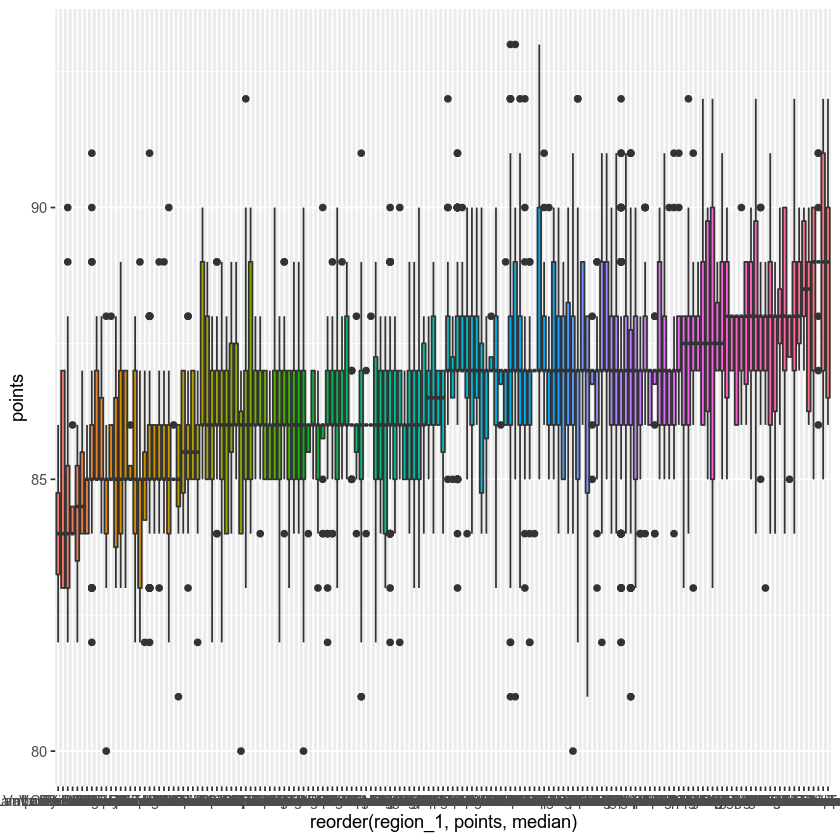

In [34]:

ggplot(filtered_wines) + geom_boxplot(aes(x = reorder(region_1, points, median), points,
                               fill = reorder(region_1, points, median)), show.legend=FALSE)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


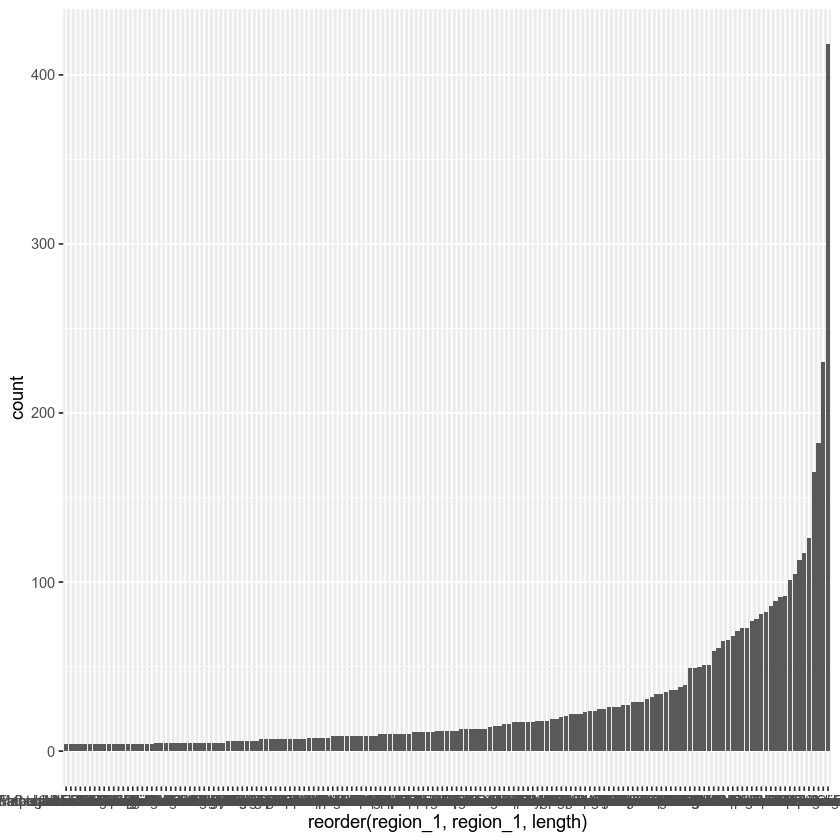

[1] 0.715055


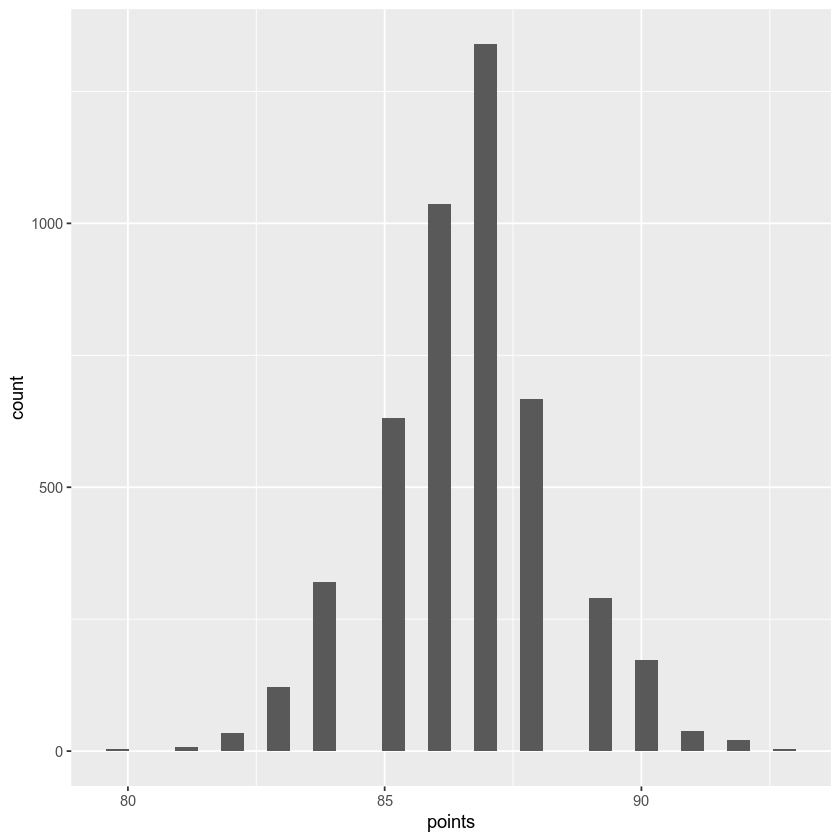

In [33]:
ggplot(filtered_wines, aes(x = reorder(region_1, region_1, length))) + stat_count()

ggplot(filtered_wines, aes(points)) + stat_bin()


compare_m_gibbs <- function(y, ind, maxiter = 500)
{
  
  ### weakly informative priors
  a0 <- 2 ; b0 <- 1 ## tau_w hyperparameters
  eta0 <- 2 ; t0 <- 1 ## tau_b hyperparameters
  mu0<- 3 ; gamma0 <- 1/0.64
  ###
  
  ### starting values
  m <- nlevels(factor(ind))
  ybar <- theta <- tapply(y, ind, mean)
  tau_w <- mean(1 / tapply(y, ind, var)) ##within group precision
  print(tau_w)
  mu <- mean(theta)
  tau_b <- 1/var(theta) ##between group precision
  n_m <- tapply(y, ind, length)
  an <- a0 + sum(n_m)/2
  ###
  
  ### setup MCMC
  theta_mat <- matrix(0, nrow=maxiter, ncol=m)
  mat_store <- matrix(0, nrow=maxiter, ncol=3)
  ###
  
  ### MCMC algorithm
  for(s in 1:maxiter) 
  {
    
    # sample new values of the thetas
    for(j in 1:m) 
    {
      taun <- n_m[j] * tau_w + tau_b
      thetan <- (ybar[j] * n_m[j] * tau_w + mu * tau_b) / taun
      theta[j]<-rnorm(1, thetan, 1/sqrt(taun))
    }
    
    #sample new value of tau_w
    ss <- 0
    for(j in 1:m){
      ss <- ss + sum((y[ind == j] - theta[j])^2)
    }
    bn <- b0 + ss/2
    tau_w <- rgamma(1, an, bn)
    
    #sample a new value of mu
    gammam <- m * tau_b + gamma0
    mum <- (mean(theta) * m * tau_b + mu0 * gamma0) / gammam
    mu <- rnorm(1, mum, 1/ sqrt(gammam)) 
    
    # sample a new value of tau_b
    etam <- eta0 + m/2
    tm <- t0 + sum((theta-mu)^2)/2
    tau_b <- rgamma(1, etam, tm)
    
    #store results
    theta_mat[s,] <- theta
    mat_store[s, ] <- c(mu, tau_w, tau_b)
  }
  colnames(mat_store) <- c("mu", "tau_w", "tau_b")
  return(list(params = mat_store, theta = theta_mat))
}

filtered_wines$region_index <- as.numeric(factor(filtered_wines$region_1))


fit2 <- compare_m_gibbs(filtered_wines$points, filtered_wines$region_index)


In [35]:
apply(fit2$params, 2, mean)

mu       tau_w       tau_b 
5.152929485 0.429280621 0.003109887

# Regression

In [39]:
library(dplyr)
library(ggplot2)
library(tidyverse)
install.packages("imputeTS")
install.packages("Boruta")
install.packages("GGally")
library(imputeTS)
library(GGally)
library(Boruta)


Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  2.1.1     ✔ purrr   0.3.2
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ gridExtra::combine() masks dplyr::combine()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::lag()         masks stats::lag()
✖ MASS::select()       masks dplyr::select()
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Registered S3 method overwritten by 'GGally':


In [40]:

wine_full <- read.csv("./winemag-data-130k-v2.csv")
head(wine_full)

us_wines <-  wine_full %>% filter(country == 'US')

## missing data imputation
cat('Rows and Columns -> ')
dim(us_wines)
cat('Complete cases -> ', sum(complete.cases(us_wines)))
cat('Total null values -> ' , sum(is.na(us_wines)))
list_na <- colnames(us_wines)[apply(us_wines, 2, anyNA)]
cat('Columns with null values -> ')
list_na

nulls <- sapply(us_wines, function(x) sum(is.na(x)))
cat('null count for each column -> ')
nulls
cat('Using imputeTS to fill NA values with mean ... ')

mean_fill <- us_wines %>% na_mean()


X,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",Vulkà Bianco,87,NA,Sicily & Sardinia,Etna,,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's already drinkable, although it will certainly be better from 2016.",Avidagos,87,15,Douro,,,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.",,87,14,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.",Reserve Late Harvest,87,13,Michigan,Lake Michigan Shore,,Alexander Peartree,,St. Julian 2013 Reserve Late Harvest Riesling (Lake Michigan Shore),Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.",Vintner's Reserve Wild Child Block,87,65,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child Block Pinot Noir (Willamette Valley),Pinot Noir,Sweet Cheeks
5,Spain,"Blackberry and raspberry aromas show a typical Navarran whiff of green herbs and, in this case, horseradish. In the mouth, this is fairly full bodied, with tomatoey acidity. Spicy, herbal flavors complement dark plum fruit, while the finish is fresh but grabby.",Ars In Vitro,87,15,Northern Spain,Navarra,,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (Navarra),Tempranillo-Merlot,Tandem


Rows and Columns -> 

[1] 54504    14

Complete cases ->  54265Total null values ->  239Columns with null values -> 

[1] "price"

null count for each column -> 

X               country           description 
                    0                     0                     0 
          designation                points                 price 
                    0                     0                   239 
             province              region_1              region_2 
                    0                     0                     0 
          taster_name taster_twitter_handle                 title 
                    0                     0                     0 
              variety                winery 
                    0                     0

Using imputeTS to fill NA values with mean ... 

In [41]:
cat('Missing values after filling with mean -> ', sum(is.na(mean_fill)))
us_wines <- mean_fill

Missing values after filling with mean ->  0

In [13]:
diabetes_df <- read.csv("./winemag-data-130k-v2.csv")

In [14]:
lm1 <- lm(y~., diabetes_df)

ERROR: Error in eval(predvars, data, env): object 'y' not found


In [17]:
diabetes_df <- read.csv("https://www.scss.tcd.ie/~arwhite/Teaching/CS7DS3/diabetes.csv")
diabetes_df$sex <- factor(as.numeric(diabetes_df$sex < 0))

In [18]:
head(diabetes_df)

y,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu
1.6715721,1.2572939,1,-0.4472018,1.83302486,0.9494822,0.6629009,-0.98873215,1.4954096,1.66154271,2.8478484
0.8024920,0.9521607,1,-0.4019337,0.45931945,0.5738471,-0.2840600,2.10384360,-0.8293610,0.37303304,-0.2835844
-0.7929835,0.1130443,1,1.2503522,-1.17948700,0.5160570,1.1100769,-0.91141776,1.0692016,-0.08861705,-0.6315214
1.1656896,0.2656109,1,0.3223560,-0.69748510,0.8627972,0.6760532,-0.06095943,-0.0544375,0.94638954,-1.4143796
-1.4285795,-1.1074887,0,-0.8546148,-1.42048794,-0.6686384,-0.7772688,0.78949891,-0.8293610,-0.72499802,1.4561005
-0.4427572,-0.8786387,0,-0.6282742,-0.04678254,0.4582670,0.7681188,0.24829815,-0.0544375,-0.86478809,1.3691163


In [45]:
library("dplyr")
library("ggplot2")
library(MCMCpack)
library(gridExtra)
library(dplyr)


data<-read.csv('./winemag-data-130k-v2.csv')
data<-droplevels(na.omit(data))


italian_wines_df = filter(data, (country == "Italy"  & price < 20))
italian_wines_df = filter(italian_wines_df, (region_1 !="Sardinia"))
counter = table(italian_wines_df$region_1)
counter = as.data.frame(counter)
counter = counter[-1,]
counter = counter %>% filter(Freq >= 4)
italian_wines_df <- italian_wines_df[italian_wines_df$region_1 %in% counter$Var1, , drop = FALSE]

compare_m_gibbs <- function(y, ind, maxiter = 2000)
{
  
  ### weakly informative priors
  a0 <- 2 ; b0 <- 1 ## tau_w hyperparameters
  eta0 <- 2 ; t0 <- 1 ## tau_b hyperparameters
  mu0<- 3 ; gamma0 <- 1/0.64
  ###
  
  ### starting values
  m <- nlevels(factor(ind))
  ybar <- theta <- tapply(y, ind, mean)
  tau_w <- mean(1 / tapply(y, ind, var)) ##within group precision
  print(tau_w)
  mu <- mean(theta)
  tau_b <- 1/var(theta) ##between group precision
  n_m <- tapply(y, ind, length)
  an <- a0 + sum(n_m)/2
  ###
  
  ### setup MCMC
  theta_mat <- matrix(0, nrow=maxiter, ncol=m)
  mat_store <- matrix(0, nrow=maxiter, ncol=3)
  ###
  
  ### MCMC algorithm
  for(s in 1:maxiter) 
  {
    
    # sample new values of the thetas
    for(j in 1:m) 
    {
      taun <- n_m[j] * tau_w + tau_b
      thetan <- (ybar[j] * n_m[j] * tau_w + mu * tau_b) / taun
      theta[j]<-rnorm(1, thetan, 1/sqrt(taun))
    }
    
    #sample new value of tau_w
    ss <- 0
    for(j in 1:m){
      ss <- ss + sum((y[ind == j] - theta[j])^2)
    }
    bn <- b0 + ss/2
    tau_w <- rgamma(1, an, bn)
    
    #sample a new value of mu
    gammam <- m * tau_b + gamma0
    mum <- (mean(theta) * m * tau_b + mu0 * gamma0) / gammam
    mu <- rnorm(1, mum, 1/ sqrt(gammam)) 
    
    # sample a new value of tau_b
    etam <- eta0 + m/2
    tm <- t0 + sum((theta-mu)^2)/2
    tau_b <- rgamma(1, etam, tm)
    
    #store results
    theta_mat[s,] <- theta
    mat_store[s, ] <- c(mu, tau_w, tau_b)
  }
  colnames(mat_store) <- c("mu", "tau_w", "tau_b")
  return(list(params = mat_store, theta = theta_mat))
}

italian_wines_df$region_index <- as.numeric(factor(italian_wines_df$region_1))


fit2 <- compare_m_gibbs(italian_wines_df$points, italian_wines_df$region_index)

apply(fit2$params, 2, mean)
apply(fit2$params, 2, mean)
apply(fit2$params, 2, sd)
mean(1/sqrt(fit2$params[, 3]))
sd(1/sqrt(fit2$params[, 3]))


theta_hat=apply(fit2$theta,2,mean)
result<-data.frame(size = tapply(italian_wines_df$points, italian_wines_df$region_index, length), 
                  theta_hat = theta_hat)
result$region_name = row.names(result)
result<-filter(result, theta_hat > 86.57671)
result

[1] 0.715055


mu        tau_w        tau_b 
4.4890591523 0.4299277252 0.0008023712

mu        tau_w        tau_b 
4.4890591523 0.4299277252 0.0008023712

mu       tau_w       tau_b 
4.136402888 0.008982648 0.016993689

[1] 81.43035

[1] 6.150097

size,theta_hat,region_name
17,87.74769,1
4,86.73969,2
165,87.43190,3
7,87.70754,4
9,87.10347,5
39,87.05337,7
59,87.10068,9
27,87.29139,10
10,87.28841,12
5,86.60933,14
